In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torchvision
import pandas as pd
import seaborn as sns
from tqdm import tqdm

Here we just extract the images,age and race from the filnames and forming a pandas dataframe from it

In [ ]:
images = []
ages = []
races = []

for i in os.listdir('part2'):
    split = i.split('_')
    ages.append(split[0])
    races.append(split[2])
    with Image.open(os.path.join('part2', i)) as img:
        images.append(img.copy())



In [4]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
races = pd.Series(list(races), name = 'Races')

df = pd.concat([images, ages, races], axis=1)
df


,Images,Ages,Races
0,<PIL.Image.Image image mode=RGB size=1002x1333...,100,0
1,<PIL.Image.Image image mode=RGB size=1002x1333...,100,0
2,<PIL.Image.Image image mode=RGB size=1002x1333...,100,0
3,<PIL.Image.Image image mode=RGB size=1002x1333...,100,0
4,<PIL.Image.Image image mode=RGB size=1282x857 ...,100,0
...,...,...,...
10714,<PIL.Image.Image image mode=RGB size=722x1127 ...,9,1
10715,<PIL.Image.Image image mode=RGB size=1042x779 ...,9,1
10716,<PIL.Image.Image image mode=RGB size=702x1163 ...,9,0
10717,<PIL.Image.Image image mode=RGB size=758x1059 ...,9,0


Let us see how one of the images looks like

In [5]:
race_map = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other'
}

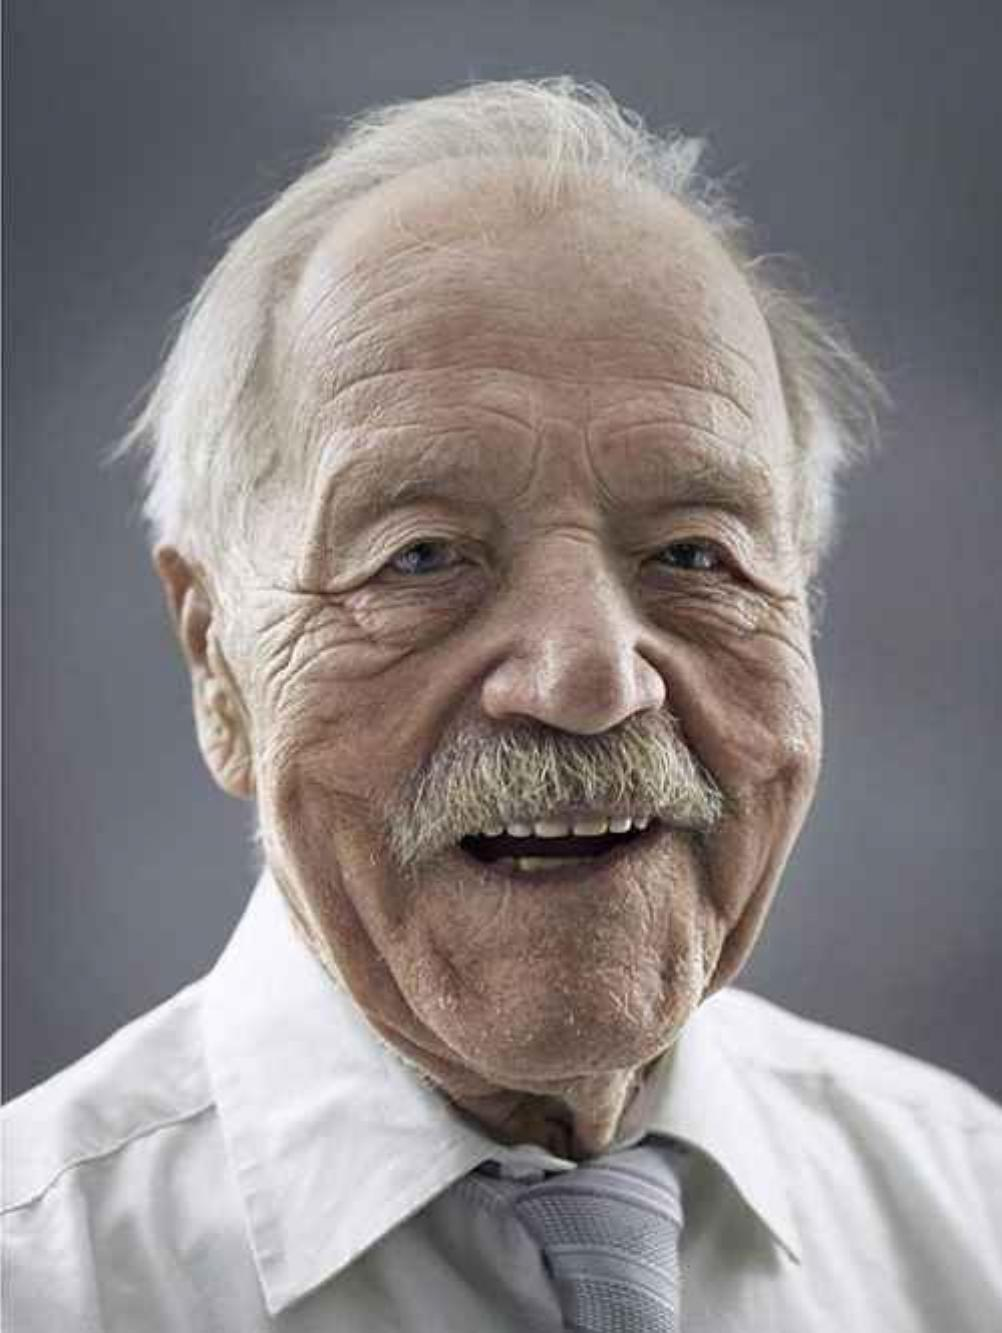

100 0


In [4]:
display(df['Images'][0])
print(df['Ages'][0], df['Races'][0])

To observe the age distribution we can plot graphs

C:\Users\preme\AppData\Local\Temp\ipykernel_19684\2896025173.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'], kde=True, bins=30)


<Axes: xlabel='Ages', ylabel='Density'>

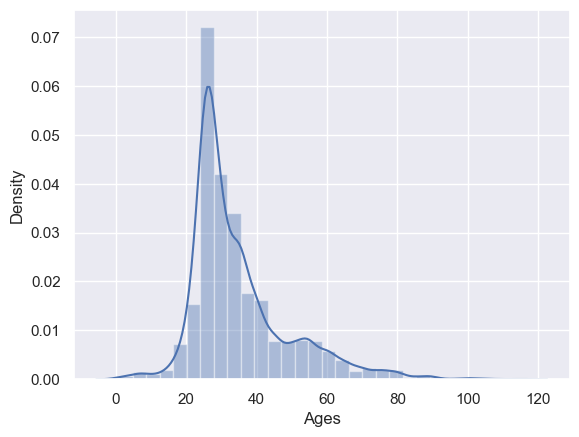

In [5]:
sns.set_theme()
sns.distplot(df['Ages'], kde=True, bins=30)

In [6]:
df['Ages'].value_counts()

Ages
26     1564
35      648
28      613
24      558
30      549
       ... 
101       1
81        1
84        1
91        1
96        1
Name: count, Length: 101, dtype: int64

In [6]:
df['Ages'] = df['Ages'].astype(int)
df = df[df['Races'].apply(lambda x: str(x).isdigit())]
df['Races'] = df['Races'].astype(int)


C:\Users\preme\AppData\Local\Temp\ipykernel_24264\2353329699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Races'] = df['Races'].astype(int)


We'll form a pytorch dataset from the pandas dataframe to feed into our vision transformer model

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # directly use PIL image from dataframe
        image = row['Images']  
        if self.transform:
            image = self.transform(image)

        age = torch.tensor(row['Ages'], dtype=torch.float32)
        race = torch.tensor(row['Races'], dtype=torch.long)

        return image, age, race


In [8]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to fixed size
    transforms.ToTensor(),          # convert to tensor
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

dataset = ImageDataset(df, transform=transform)
train_size = int(0.8 * len(dataset))  # 80% train
test_size = len(dataset) - train_size

# Split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


c:\Users\preme\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
img, age, race = dataset[0]
print(img.shape, age, race)


torch.Size([3, 224, 224]) tensor(100.) tensor(0)


In [13]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
'''from einops.layers.torch import Rearrange, repeat

class PatchEmbedding(torch.nn.Module):
    def __init__(self, in_channels=3, patch_size=8, embed_dim=768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = torch.nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            torch.nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size), # this will create the patch embeddings
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size), # we flatten height and width into number of patches and patch length for feeding into transformer
        )
        self.cls_token = torch.nn.Parameter(torch.randn(1,1, embed_dim)) # randomly initialize the cls token and make it a learnable parameter that updates during training
        self.positions = torch.nn.Parameter(torch.randn(224/patch_size ** 2 + 1, embed_dim)) # 224/patch_size ** 2 means the total number of patches, patches per row * patches per column and + 1 for the extra cls token

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b) # copies it b times for each batch, so each image in the batch has its own class token
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1) # dim 1 is the sequence dimension and concatenates the cls token with the patch embeddings
        x += self.positions
        return x
    '''

"from einops.layers.torch import Rearrange, repeat\n\nclass PatchEmbedding(torch.nn.Module):\n    def __init__(self, in_channels=3, patch_size=8, embed_dim=768):\n        self.patch_size = patch_size\n        super().__init__()\n        self.projection = torch.nn.Sequential(\n            # using a conv layer instead of a linear one -> performance gains\n            torch.nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size), # this will create the patch embeddings\n            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size), # we flatten height and width into number of patches and patch length for feeding into transformer\n        )\n        self.cls_token = torch.nn.Parameter(torch.randn(1,1, embed_dim)) # randomly initialize the cls token and make it a learnable parameter that updates during training\n        self.positions = torch.nn.Parameter(torch.randn(224/patch_size ** 2 + 1, embed_dim)) # 224/patch_size ** 2 means the tot

The above code block is similar to how tokenization occurs in nlp, it takes image tensors and converts it into a sequence of patch embeddings

cls_token is a torch Parameter randomly initialized, in the forward the method it is copied b (batch) times and prepended before the projected patches using torch.cat

After this we would feed it to the encoder part just like in a normal transformer but we don't need to manually define all this patching and attention layers as we will import a pretrained ViT now

We are importing in a pretrained vit and adding in a multi head classifier on top of it to predict both the age and the race

In [15]:
from transformers import ViTModel

model_name = "google/vit-base-patch16-224"

class MultiHeadViT(torch.nn.Module):
    def __init__(self, model_name=model_name, num_age_classes=100, num_race_classes=5):
        super().__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.age_regressor = torch.nn.Linear(self.vit.config.hidden_size, 1)

        self.race_classifier = torch.nn.Linear(self.vit.config.hidden_size, num_race_classes)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        age_pred = self.age_regressor(pooled).squeeze(-1)
        race_logits = self.race_classifier(pooled)
        return age_pred, race_logits

In [16]:
MultiHeadViT()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiHeadViT(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn):

In [17]:
images, ages, races = next(iter(train_loader))
print(images.shape)  # Shape of image batch
ages_int = [int(a) for a in ages]
ages_tensor = torch.tensor(ages_int)
print(ages_tensor.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [17]:
def train(model, dataloader, optim, device, age_criterion, race_criterion, scheduler=None):
    total_loss = 0
    model.train()
    for images, ages, races in tqdm(dataloader):
        inputs = images.to(device)
        age_labels = ages.to(device)
        race_labels = races.to(device)

        optim.zero_grad()
        age_logits, race_logits = model(inputs)

        age_loss = age_criterion(age_logits, age_labels.float())
        race_loss = race_criterion(race_logits, race_labels.long())
        loss = age_loss + race_loss

        loss.backward()
        optim.step()
    

        total_loss += loss.item() * inputs.size(0)

    return total_loss / len(dataloader.dataset)


In [ ]:
def eval(model, dataloader, device, age_criterion, race_criterion):
    model.eval()
    total_loss = 0
    total_age_error = 0     
    race_correct = 0
    total = 0

    with torch.no_grad():
        for images, ages, races in dataloader:
            inputs = images.to(device)
            age_labels = ages.to(device)
            race_labels = races.to(device)

            age_logits, race_logits = model(inputs)

            age_loss = age_criterion(age_logits, age_labels.float())
            race_loss = race_criterion(race_logits, race_labels.long())
            loss = age_loss + race_loss

            total_loss += loss.item() * inputs.size(0)

          
            total_age_error += torch.abs(age_logits - age_labels.float()).sum().item()

         
            race_pred = race_logits.argmax(dim=1)
            race_correct += (race_pred == race_labels).sum().item()

            total += inputs.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    age_mae = total_age_error / total
    race_acc = race_correct / total

    return avg_loss, age_mae, race_acc


In [ ]:
def run(train_loader, test_loader, num_age_classes=116, num_race_classes=5, batch_size=32, epochs=3, lr=5e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = MultiHeadViT(model_name=model_name, num_age_classes=num_age_classes, num_race_classes=num_race_classes).to(device)

    age_criterion = torch.nn.L1Loss()
    race_criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, device, age_criterion, race_criterion)
        val_loss, age_acc, race_acc = eval(model, test_loader, device, age_criterion, race_criterion)
        print(f"Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  age_acc={age_acc:.4f}  race_acc={race_acc:.4f}")
    
    return model

trained_model = run(train_loader, test_loader)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 268/268 [10:30<00:00,  2.35s/it]


Epoch 1/3  train_loss=18.0798  val_loss=12.9783  age_acc=12.2665  race_acc=0.7910


100%|██████████| 268/268 [10:53<00:00,  2.44s/it]


Epoch 2/3  train_loss=10.9880  val_loss=10.0845  age_acc=9.5343  race_acc=0.8190


100%|██████████| 268/268 [10:39<00:00,  2.39s/it]


Epoch 3/3  train_loss=9.3752  val_loss=8.9749  age_acc=8.4132  race_acc=0.8172


In [ ]:
torch.save(trained_model.state_dict(), "model.pth")
print("Model saved!")

Model saved!


In [18]:
model = MultiHeadViT().to('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("model.pth"))
model.eval()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiHeadViT(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn):

Let's test our model on certain images

In [19]:
img_number = 0  # Change this index to test different images
test_img = images[img_number].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')  # add batch dimension and move to device
with torch.no_grad():
    age_pred, race_logits = model(test_img)
predicted_age = round(age_pred.item(), 1)
predicted_race = race_logits.argmax(dim=1).item()

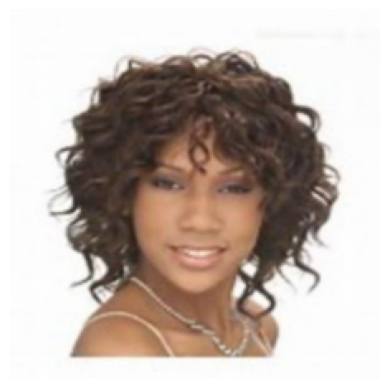

In [20]:
img_tensor = test_img.squeeze(0).cpu()  

mean = torch.tensor(processor.image_mean).view(3,1,1)
std = torch.tensor(processor.image_std).view(3,1,1)

img = img_tensor * std + mean

# Clip to valid range
img = img.clamp(0, 1)

img = img.permute(1, 2, 0).numpy()

# Show
plt.imshow(img)
plt.axis('off')
plt.show()


In [21]:
print("Predicted age:", predicted_age)
print("Predicted race:", predicted_race)


Predicted age: 26.6
Predicted race: 1


In [22]:
print("Actual age:", ages[img_number].item())
print("Actual race:", races[img_number].item())

Actual age: 30.0
Actual race: 1
